

# Введение. Постановка задачи

Задача: сегментировать покупателей по типу потребления, чтобы на них настроить рассылку. Выделить кластеры клиентов, выделяем категории товаров с учетом сезонности.


Рассматриваем природу данных, основные особенности датасета: количество строк, количество уникальных айди, названия столбцов и формат данных.


**Бизнес-задачи**

* Выявить паттерны поведения клиентов, определить сегменты для рассылки.
* Дополнительно: предложить возможные акции и предложения для лояльных покупателей, материалы для маркетингового отдела.


**Этапы работы и применяемые методы**


* Знакомство и чистка данных, приведение к нужному типу, выявление аномалий и дубликатов
* Анализ продуктов и покупателей, визуализация данных
* Расчёт затрат на популярные продукты исходя из исторических данных и наблюдений


***Декомпозиция* Содержание с ссылками на разделы**

- Знакомство с данными, чистка, приведение к форматам

- Исследовательский анализ данных

  - Выявление аномалий

- Кластеризация KMeans

- Финальные наблюдения

**Выводы исследования**

*Вынесла сюда для удобства*


Финальный датасет для коллег из CRM `segmentationdatabase`.

Датасет для Дашборда `normcustomers`.

**Наблюдение по очищенным данным**

Три четверти покупателей делают 1-2 заказа, чаще 1, и 2 покупки в заказе. Три четверти покупателей делают заказ до 1012 руб. Более 6772 руб. — аномальное значение чека.

В среднем 4 покупки. Максимальное кол-во заказов — 126, максимальная выручка с 1 клиента 129 778 руб. максимальное число позиций в заказе 1000.

Доля аномального количества позиций в заказе (более 51) 0.331%, что составляет 8.51% годовой выручки. Доля аномального числа закупок (более 3) 0.992%, что составляет 7.5% годовой выручки. Количество аномальных покупателей 1.03% и они принесли 17.0% годовой выручки.

**Бенчмарк**

Отсекаем более 7 заказов в год. Дополнительные фильтры (99% кв.): чек не более 6772 рубля и менее 1000 товарных единиц.

**Кластеризация**


Кластер два увеличил количество заказов по категории домохозяйства к концу октября 2019 года. Им можно рассылать предложения с акциями по категории товаров housekeeping (лучше, конечно, ещё подразобрать эту категорию).
Кластер 1 равномерно и регулярно делает закупки по товарам housekeeping. Им можно делать рассылку по новинкам в категории housekeeping и реже kitchen.

Кластер 0 активно и постоянно покупает товары для хозяйства и дизайна, сезонно проявляет сильный интерес к елкам в Новый год и к сезонным растениям к концу лета. В остальное время проявляет интерес к кухонной утвари и дизайну с падением интереса в летний период. Так что можно круглогодично присылать новинки по housekeeping, зимой до середины весны про кухонную утварь, к лету и НГ — про сезонные новинки.


**Тестирование**

Распределение стоимостей заказов в кластерах ненормальное, выборки небольшие. Применён критерий Манна-Уитни.

При сравнении кластеров 0 и 2 по таблице segmentationsdatabase есть основания считать, что кластеры 0 и 2 имеют стат.значимые отличия по параметру стоимости чека за заказ. Были сравнены все стоимости попавших в базу заказов.

При сравнении кластеров 0-1-2 по сводной таблице clusterwise ни одно из p-values 0,4; 1; 0,2 не меньше threshold в 0,05, у нас нет оснований отвергнуть гипотезу, что группы различаются. У нас нет достаточных доказательств, чтобы сказать, что истинные средние значения выборок. Были сравнены суммарные значения параметров кластеров.

**Дальнейшие улучшения**

В будущем можно лучше разобрать тематики, в частности в том, что касается растений и улучшить обработку данных. Пока деприоритизировала.

# Знакомство с данными


In [1]:
import numpy as np
import pandas as pd
!pip install seaborn==0.11.0
!pip install bioinfokit
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
from datetime import datetime
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import plotly
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats as stats
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
pd.options.display.float_format = '{:.2f}'.format

In [2]:
try:
    data = pd.read_csv('/content/ecommerce_dataset.csv')
except:
    data = pd.read_csv('/datasets/ecommerce_dataset.csv')

print('Исходные данные содержат: ', 
      'Столбцы: {}'.format(data.columns), data.index)
print(data.info())

Исходные данные содержат:  Столбцы: Index(['date', 'customer_id', 'order_id', 'product', 'quantity', 'price'], dtype='object') RangeIndex(start=0, stop=6737, step=1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB
None


<AxesSubplot:>

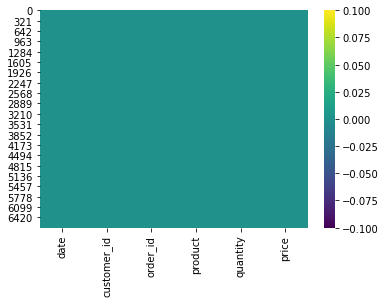

In [3]:
cols =data.columns
sns.heatmap(data[cols].isnull(), cmap='viridis')

<AxesSubplot:>

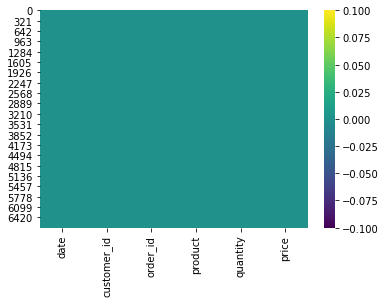

In [4]:
sns.heatmap(data[cols].isna(), cmap='viridis')

In [5]:
data.drop(columns = 'date').isna().sum()

customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [6]:
#Исправляю тип данных
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')
data['date'] = data['date'].dt.strftime('%Y-%m-%d')
sum(data['date'].isna())

0

In [7]:
print('Доля дублей {:2}%'.format(len(data[data.drop(columns = 'date')['order_id'].duplicated()]) / len(data) * 100))

Доля дублей 58.675968531987536%


In [8]:
duplicates = data.drop(columns = 'date').groupby('order_id')['customer_id'].value_counts() > 1

In [9]:
duplicates = data[data.drop(columns = 'date')['order_id'].duplicated()]
print(len(duplicates))
data = data.drop_duplicates(subset=['order_id'],keep='first')
print(len(data))
data.describe()

3953
2784


,order_id,quantity,price
count,2784.00,2784.00,2784.00
mean,64651.17,3.72,776.81
std,17508.19,22.95,1159.76
min,12624.00,1.00,9.00
25%,69112.50,1.00,134.00
50%,70454.00,1.00,314.50
75%,71848.25,1.00,974.00
max,73164.00,1000.00,14917.00


In [10]:
data['product'] = data['product'].str.replace('Ё','Е').str.replace('ё','е').str.replace('-',' ').str.replace('для','').str.replace(', ',' ')

In [11]:
data['shortname'] = data['product'].apply(lambda x: x.split()[0]+' '+x.split()[1])

In [12]:
#MONKEYJOB
productsinlist = data['shortname'].value_counts()
products10 = sorted(productsinlist[productsinlist > 10].index)
productsless10 = sorted(productsinlist[productsinlist < 10].index)
#display(productsless10)

In [13]:
#MONKEYJOB
cat_dict = dict({'(1) kitchen' : ['Электроштопор','Салатник Luminarc', 'Кружка МАРЛИ', 'Кружка ТАЧКИ' 'Миксер электрический', 'Форма выпечки', 'Блюдо Pasabahce', 'Термокружка Забава', 'Рассада Капусты', 'Роза садовая', 'Гвоздика садовая', 'Вербена микс', 'Цитрофортунелла Кумкват', 'Пеперомия d',\
                                  'Гортензия метельчатая','Кружка ТАЧКИ', 'Миксер электрический', 'Кружка МАРЛИ', 'Термокружка вакуумная','Чайник заварочный', 'Форма АLPENKOK', 'Орехоколка VIVA', 'Термокружка Яромир',  'Кастрюля круглая',\
'Кружка прозрачная','Пресс чеснока','Термостакан WEBBER', 'Банка РОНДО', 'Нож мясорубки','Термос 1л',  'Электроштопор QWERTY','Контейнер СВЧ', 'Столовый нож', 'Блюдце УТРО','Нож овощей', 'Миксер ВАСИЛИСА', 'Мантоварка пароварка',  'Кружка мерная',  'Столовая ложка', 'Подставка ножей', 'Просеиватель муки',\
                                  'Кастрюля чугунная','Толкушка деревянная','Вешалка НИКА', 'Швабра пола',  'Хлебница деревянная', 'Кружка Luminarc', 'Тарелка суповая', 'Кувшин Luminarc','Термос со', 'Термокружка Alpenkok','Кружка БАМБУК', \
                                  'Тарелка десертная','Банка стеклянная', 'Овощеварка алюминиевая', 'Терка WEBBER',  'Овощечистка с', 'Чайник электрический','Лоток холодца',  'Муляж Зеленое','Салатник РОМАНТИК',  'Салатник АМОРИ',\
                                  'Кружка чая', 'Мантоварка алюминиевая', 'Коврик кухонный', 'Кружка НОРДИК', 'Ополаскиватель посудомоечных','Тарелка обеденная','Терка сыра', 'Пьезозажигалка с','Салатник ЭМПИЛАБЛЬ','Миксер DELTA','Щетка посуды', 'Контейнер овощей','Масленка КОРОВКА',\
'Толкушка картофеля', 'Ерш бутылки', 'Банка со','Банка с','Чайник эмалированный', 'Чайник со', 'Нож стейка', 'Хлебница пластмасовая','Шприц кондитерский',   'Нож поварской',  'Кастрюля алюминиевая','Салатник КАРИН', 'Ерш бутылочный',\
                                  'Скатерть Лувр', 'Емкость СВЧ', 'Скатерть прямоугольная','Набор бокалов', 'Миска пластмассовая', 'Антижир POSH','Скатерть Сидней', \
                              'Кофе Арабика', 'Тортница CURVER', 'Скатерть 150х120','Набор стаканов', 'Мантоварка','Подставка яйца',  'Масленка','Мини сковорода', 'Миска ', 'Миксер', 'Мерный стакан',\
                              'Сито WEBBER', 'Сковорода HARD','Кружка с', 'Миска Фазенда', 'Скатерть Муза', 'Набор форм', 'Кухонные ножницы', 'Жестяная банка',\
                              'Картофелемялка металлическая','Кисточка силиконовая', 'Набор бокалов', 'Измельчитель овощей', 'Набор фужеров', 'Набор эмалированных',\
                              'Сервировочная салфетка', 'Салфетка Камушки', 'Набор посуды', 'Мерный стакан', 'Соковарка WEBBER', 'Кипятильник электрический',\
                              'Противень прямоугольный', 'Вилка столовая','Салатник АСПЕН',  'Хлебница Webber', 'Кастрюля эмалированная', 'Кружка О',  'Набор кружек', 'Котел алюминиевый', 'Столовый','Столовая', 'Овощеварка', 'Нож', 'Овощечистка', 'Орехоколка',\
                              'Отделитель косточек', 'Набор ножей', 'Скатерть 350х150', 'Половник',  'Полотенце', 'Сковорода Scovo', 'Скатерть из', 'Сковорода алюминиевая',\
                              'Скатерть Азалия', 'Чайный набор', 'Рыбочистка','Вилка', 'Ложка', 'Ложка столовая',\
                              'Ложка чайная', 'Сотейник алюминиевый', 'Скатерть Рим', 'Венчик', 'Tepмокружка AVEX', 'Стеклянная крышка', 'Салфетка Protec', 'скатерть', 'Губка',\
                              'Кипятильник электрический', 'Скатерть 180', 'Мини сковорода', 'Кисточка силиконовая', 'Кувшин','Отделитель косточек', \
                              'Кухонное полотенце', 'Скалка силиконовая', 'Разделочная доска', 'Кухонные ножницы',  'Контейнер герметичный',\
                              'Кружка', 'Скатерть Towa', 'Скатерть Джулия', 'Набор столовых', 'Крышка оцинкованная',  'Котел алюминиевый',  'Измельчитель овощей',\
                              'Кофе Арабика', 'Фарфоровая кружка', 'Скатерть виниловая',  'Пряные травы', 'Пьезозажигалка',  'Противень прямоугольный', 'Пряные травы',\
                              'Разделочная доска', 'Скатерть Ажурная', 'Скатерть Dasch','Скатерть Беатрис', 'Бульонница Luminarc', 'Блюдо',\
                              'Скатерть круглая',  'Доска разделочная',  'Картофелемялка металлическая',  'Кастрюля','Чайная ложка', 'Салфетка махровая', 'Мыльница пластмассовая',  'Вантуз черный', \
                              'Блюдце','Антижир POSH','Соковарка алюминиевая', 'Кухонное полотенце',  'Скатерть Жаклин','Весы настольные', \
                              'Соковыжималка цитрусовых',  'Бульонница Luminarc','Банка', 'Набор махровых', 'Весы настольные', 'Вакуумный пакет',\
                              'Антинакипин ','Увлажняющая маска', 'Фарфоровая кружка', 'Хлебница','Форма', 'Шприц','Половник Attribute', 'Коробка хранения','Сумка тележка',  'Швабра Leifheit',\
                              'Сотейник алюминиевый', 'Термокружка','Скатерть Meiwa','Жестяная банка', 'Чайник', 'Чайный набор', 'Тарелка','Чехол Eurogold', 'Корзина мягкая', 'Доска гладильная',\
                              'Таз','Термостакан', 'Скатерть 350х180', 'Скатерть Арлет', 'Столов', 'Отбеливатель Пероксоль',  'Термос', 'Толкушка', 'Терка', 'Салатник', 'Тортница CURVER','Стакан',\
                              'Стакан низкий', 'Стакан пластмассовый', 'Стеклянная крышка', 'Универсальное средство', 'Универсальный нож'],
    '(2) bath' : ['Ерш унитазный','Ванна 70','Коврик туалета','Штанга ванной', 'Карниз ванной',  'Коврик ванной',  'Корзина белья','Ерш туалета','Мыло скраб', 'Стакан ванной','Махровый халат' 'Комплект ванной', 'Паста зубная', 'Мыло ручной', 'Миска варенья',\
              'Сахарница фарфоровая', 'Паста зубная','Увлажняющая маска', 'Штора ванной','Ерш унитаза','Щетка палубная',  'Подголовник ванной', 'Корыто оцинкованное','Коврик противоскользящий','Мыло жидкое', 'Комплект махровых', 'Сиденье унитаза','Жидкое мыло', 'Зубная паста', 'Мыло ', 'Мыльница','Махровое полотенце',  'Махровый халат',\
              'Бальзам', 'Ванна', 'Халат вафельный','Щетка унитаза', 'Махровое полотенце', 'Халат вафельный', 'Комплект ванной', 'Фен дорожный', 'Емкость соуса','Щетка', 'Корыто', 'Коврик влаговпитывающий'],

    '(3) housekeeping' : ['Настенная сушилка', 'Вешалка металлическая', 'Корзина пластиковая','Стремянка FRAMAR', 'Стремянка Eurogold', 'Простынь вафельная', 'Вешалка Valiant',  'Полки QWERTY', 'Вешалка перекладина',  'Контейнер мусора',\
                          'Щетка мытья', 'Перчатки Fabrikators', 'Средство мытья', 'Кофр хранения',  'Средство быстрого', 'Простыня двуспальная', 'Перчатки Extra', 'Щетка универсальная','Коврик придверный', 'Коврик интерьерный', 'Коврик хлопковый', 'Кувшин пластмассовый',  'Ковер придверный', 'Перчатки латексные', 'Стремянка алюминиевая',  'Тележка багажная','Простыня на',\
                          'Штора текстильная', 'Перчатки Latex',   'Ручка мебельная', 'Вешалка слуга', 'Ткань гигиенических','Покрытие гладильной',\
                      'Измерительный угольник', 'Сушилка уличная','Коврик резиновый', 'Вешалка костюма', 'Шнур хозяйственный', 'Стяжка оконная', 'Петля приварная','Чехол одежды','Тележка хозяйственная','Ведро мусора','Вешалка деревянная', 'Стремянка бытовая','Подрукавник Gimi', 'Утюг электрический','Щетка смахивания','Веник сорго', 'Коробка INFINITY','Ящик почтовый','Стремянка DOGRULAR','Прищепки белья','Ведро Полимербыт',  'Настольная гладильная','Весы электронные','Сиденье ванны','Держатель туалетной', \
                      'Наматрацник Natures','Чехол короткой',  'Простыня сатиновая', 'Ткань окон', 'Подушка 40х40', 'Стремянка 7','Автоматическая щетка', 'Набор прецизионных', 'Концентрат мытья', 'Комплект мытья', 'Кондиционер белья',\
                      'Сиденье в', 'Плечики пластмассовые','Антинакипин утюгов', 'Универсальный нож', 'Уголок оконный', 'Вакуумный пакет', 'Тряпка кафеля',\
                      'Совок металический', 'Совок золы', 'Двуспальное постельное', 'Решетка вентиляционная', 'Многофункциональный инструмент','Подрукавник Leifheit', \
                      'Запасная насадка', 'Дозатор мыла','Насадка ведра',       'Штангенциркуль 150',  'Утюг DELTA', 'Ведро овальное', 'Корзина на', 'Рукав гладильной', 'Коробка прямоугольная', 'Венчик с',  'Бак белья',       'Щетка труднодоступных', 'Вешалка надверная', 'Швабра мытья', 'Средство против', 'Полка обуви', 'Окномойка с', 'Урна пепельница', 'Веник подметания', 'Щетка хозяйственная',  'Швабра хозяйственная',\
                          'Ткань универсальная',  'Этажерка обуви','Одеяло Wellness', 'Тряпкодержатель с', 'Ведро ягод','Наволочка Wellness',  'Мусорный контейнер', 'Вешалка плечики', 'Ароматизированное средство','Автоматическая щетка', 'Сушилка белья', 'Тряпка', 'Тряпкодержатель',\
                      'Уголок оконный','Бельевые прищепки', 'Сверло по','Совок и','Сетка стирки','Крючок проволочный', 'Защитный экран', \
                      'Фиксатор шар', 'Весы напольные', 'Весы электронные', 'Веревка полипропиленовая', 'Вешалка',  'Вешалки мягкие',  'Вкладыши для',\
                      'Гладильная', 'Дозатор мыла',  'Мусорный контейнер',   'Лестница стремянка', 'Готовая скатерть', 'Набор вешалок','Ароматизированное средство'\
                      'Набор ковров', 'Стяжка', 'Скребок 44','Этажерка цветочная', 'Бидон пластмассовый', 'Вешалка блузок', 'Камнеломка Арендса', 'Вантуз с', 'Вешалка верхней', 'Таз алюминиевый', 'Шпагат полипропиленовый', 'Стремянка Scab', 'Ведро без', 'Насадка моп', 'Обувница 3','Рассекатель пламени', 'Сетка глажения','Гипоаллергенный концентрированный',\
                      'Скребок окон', 'Дозатор',  'Двуспальное постельное',  'Держатель для','Модульная стеклянная', 'Ложка обувная',  'Ковш пластмассовый', 'Комод Эльфпласт',\
                      'Емкость', 'Завертка форточная', 'Холодная сварка', 'Вешалки мягкие',  'Крепеж пружины',   'Вкладыши хранения','Шнур резиновый', 'Урна уличная',        'Стремянка 5', 'Рыбочистка металлическая', 'Измерительный алюминиевый', 'Коврик Sochi','Коврик ворсовый',  'Вешалка напольная', 'Бензин зажигалок', 'Стремянка металлическая', 'Вешалка настенная',\
                          'Подрукавник складной', 'Стремянка Colombo', 'Насадка отжим','Ведро пластиковое', 'Пылесос DELTA', 'Контейнер продуктов', 'Чехол костюма', \
                          'Корзина глаженного', 'Ведро AMPARI',  'Сушилка Meliconi', 'Шило с','Банка из',   'Термометр на',  'Вешалка гардеробная', 'Вешалка с',\
                      'Весы напольные', 'Комплект постельного','Подставка обуви', 'Вешалка сушилка', 'Коврик Bacchetta','Ручка скоба', 'Коврик Dasch', 'Коврик в', 'Петля рояльная', 'Одеяло Silver', 'Швабра многофункциональная','Этажерка 2', 'Сумка хозяйственная', \
                          'Складная картонная',  'Стремянки Colombo','Сметка с',  'Паста полировки',\
                      'Запасная насадка', 'Набор прищепок', 'Перчатки', 'Отжим',  'Отбеливатель Пероксоль', 'Ополаскиватель', 'Обувница 3', 'Одеяло',  'Окномойка',\
                      'Петля',  'Подголовник Bacchetta',  'Подголовник','Сиденье гладильной','Салфетка на','Защитная соль',\
                      'Пододеяльник', 'Подушка',  'Покрывало ', 'Прищепки',  'Пробка','Нетканые салфетки', 'Фал капроновый',\
                      'Просеиватель', 'Простынь',  'Простыня','Пружина дверная',  'Пылесос', 'Рассекатель пламени', 'Решетка вентиляционная',\
                      'Ролик', 'Защитный экран',  'Камнеломка',  'Карниз алюминиевый', 'Корзина', 'Корзинка', 'Измерительный', 'Защитная соль',\
                      'Гипоаллергенный концентрированный', 'Вешалка стойка', 'Ковш пластмассовый', 'Кольца для','Крючок одежный',  'Крючок проволочный', 'Крепеж для',\
                      'Ложка обувная','Щетка сметка', 'Сумка тележки', 'Сменная насадка','Чехол гладильной', 'Ложка кухонная', 'Кондиционер', 'Концентрат для', 'Стеллаж обуви',\
                      'Складной детский', 'Шпингалет 80','Лестница стремянка',  'Лестница стремянка', 'Линейка, длина', 'Кофр',\
                      'Мешок для', 'Лопатка',  'Лоток', 'Многофункциональный инструмент', 'Модульная стеклянная', 'Мусорный контейнер','Утюг',\
                      'Фал капроновый','Фиксатор шар','Веревка полипропиленовая',  'Крышка оцинкованная',   'Завертка форточная',\
                      'Покрывало стеганый', 'Холодная сварка', 'Чистящий крем', 'Шило','Мешок строительного', 'Набор инструментов',\
                      'Шнур','Шпингалет','Штанга','Шпагат', 'Стяжки чехла',  'Штангенциркуль','Таз', 'Таз пластмассовый', 'Сушилка', 'Чехол',\
                      'Вешалка','Ящик', 'Вешалка брюк', 'Швабра','Крючок одежный', 'Корзина', 'Карниз', 'Доска', 'Этажерка', 'Сумка тележка',\
                      'Щетка сметка', 'Мешок деликатной', 'Стяжка', 'Средство', 'Петля стрела', 'Сумка', 'Ерш','Ящик хранения', 'Набор прищепок', 'Гладильная доска',\
                      'Бельевые прищепки', 'Бензин', 'Бидон','Коврик', 'Корзина', 'Контейнер', 'Мусорный контейнер', 'Вантуз',\
                      'Ведро', 'Веник','Подкладка под', 'Чехол', 'Энотера', 'Эпипремнум', 'Физостегия Вергинская', 'Чехол',\
                      'Термометр', 'Тележка', 'Стремянка', 'Насадка',  'Настенная сушилка',  'Настольная гладильная', 'Наволочка',\
                          'Насадка на', 'Насадка мытья',  'Пододеяльник 214х150', 'Отжим ведра',
'Полотенце прессованное','Ерш радиаторный', 'Стремянка Framar', 'Стремянка COLOMBO',\
                      'Наматрасник', 'Наматрицник чехол', 'Покрытие', 'Полка', 'Пресс',  'Рукав',  'Ручка',  'Нож универсальный',\
                      'Ножеточка универсальная','Настенная сушилка', 'Набор сверел', 'Крючок одежный',   'Подрукавник', 'Стремянка табурет', 'Лестница'],
    '(4) seasonal' : ['Рассада','Алоэ Вера', 'Клен ложноплатановый',   'Розмарин в',    'Колокольчик Карпатский', 'Антуриум Андрианум',\
                  'Амариллис Red', 'Базилик овощной',   'Мединилла Магнифика',  'Цикламен розовый', 'Хамедорея d',  'Однолетнее растение', 'Синнингия (глоксиния)', 'Пуансетия d',\
                  'Гиностемма укорененный', 'Лавр d', 'Новогоднее дерево','Гардения d',  'Нефролепис Бостон',  'Вероника колосковая', 'Лук порей', 'Джункус Пенсил',\
                  'Драцена фрагранс', 'Котовник Блю', 'Виола рассада', 'Основание пробки', 'Ведро резинопластиковое', \
                  'Гайлардия крупноцветковая', 'Осина обыкновенная', 'Душица обыкновенная',  'Петрушка', 'Колеус рассада', 'Чабер Bolero',\
                  'Ранункулус Клуни', 'Петуния', 'Пиретрум Робинсон',  'Платикодон махровый',  'Портулак рассада',  'Примула', 'Пуансетия ',\
                  'Радермахера','Ранункулус Клуни',  'Рассада', 'Роза', 'Розмарин', 'Рудбекия',\
                  'Глоксиния', 'Годеция', 'Гипсофила Аврора', 'Георгина Черная', 'Вербейник монетчатый', 'Виола рогатая',\
                  'Горох Амброзия', 'Многолетнее растение', 'Гортензия',  'Вероника', 'Виола', 'Хризантема сиреневая', \
                  'Вигна Лилиана', 'Гайлардия крупноцветковая',  'Буддлея Вейера', 'Бузульник',\
                  'Валериана', 'Агератум рассада',  'Дендробиум', 'Джункус Пенсил', 'Драцена фрагранс', 'Девичий виноград',\
                  'Зверобой продырявленный',  'Земляника',  'Змееголовник молдавский',  'Кодонанта укорененный',\
                  'Колеус рассада', 'Колокольчик', 'Кореопсис', 'Кориандр', 'Ножеточка', 'Космея', 'Котовник Блю', 'Крассула', 'Крокусы Pickwick', \
                  'Лаванда', 'Лаватера Монт', 'Девичий виноград',\
                  'томата (помидор)',  'Лавр',  'Лантана',  'Лапчатка',  'Левкой рассада',  'Лен',  'Лилейник высокорослый',\
                  'Лук порей', 'Львиный зев',  'Любисток Удалец', 'Литопс', 'Лобелия',  'Мединилла',  'Мелисса', 'Маттиола Ночная',\
                  'Мимоза стыдливая',  'Настурция',  'Незабудка смесь',  'Нефролепис Бостон', 'Нивянник','Калоцефалус Брауни',\
                   'Нетканые салфетки','Пеперомия', 'Подсолнечник',  'Мирт',  'Молодило', \
                  'Монарда', 'Морковь', 'Муррайя', 'Мускари', 'Мята',  'Гардения d',  'Гвоздика', 'Георгина Черная', 'Газания рассада','Гербера', 'Гиацинт', 'Гимнокалициум Микс',\
                  'Гиностемма укорененный','Вербена', 'Агератум рассада','Роза кордана', 'Роза кустовая','Роза одноголовая',\
                      'Роза Патио', 'Фиалка d', 'Пеларгония розебудная',  'Адиантум Лиза',  'Аквилегия', 'Антуриум', 'Артемизия', 'Баклажан',\
                  'Бакопа', 'Аспарагус', 'Астра', 'Афеляндра', 'Бадан', 'Крокусы Pickwick',\
                  'Базилик', 'Аптения', 'Клен', 'Клубника','Кипарисовик', 'Бальзамин', 'Барвинок', 'Бархатцы', 'Бегония', 'Аргирантерум рассада','Алиссум',\
                  'Алоэ Вера',  'Анемона','Тимьян', 'Арбуз',  'Мимоза стыдливая','Пеларгония зональная', \
                  'Аргирантерум рассада', 'Зверобой продырявленный','Кампанула', 'Капсикум',\
                  'Капуста', 'Томат', 'Табак', 'Укроп Обильнолистный', 'Хризантема','Дыня Млада', 'Петуния махровая',  'Эхеверия Лила', 'Шеффлера Голд',\
                  'Фиттония','Подсолнечник низкорослый', 'Ель канадская', 'Аптения d', 'Роза Палас', 'Пеларгония Грандифлора', 'Цинния', 'Цинерария','Эшшольция', 'Эхинацея', 'Юкка','Ясколка','Газания рассада', 'Петуния',\
                  'Флокс', 'Тюльпан', 'Альбука',  'Амариллис','Тыква', 'Фиалка', 'Циперус', 'томатa', 'Бакопа ампельная', 'Эхеверия',\
                  'Однолетнее растение', 'Новогоднее дерево','Декабрист','Патиссон', 'Папоротник', 'Осина обыкновенная',\
                     'Овсянница сизая',  'Огурец',  'Пахира Акватика',  'Пеларгония', 'Калибрахоа', 'Иссоп',  'Кабачок',  'Каланхое',\
                  'Калатея', 'Лавр нобилис', 'Рассада в', 'Бальзамин Валера', 'Земляника садовая',  'Базилик Застольный',\
                      'Табак душистый','Альбука Спиралис',  'Бальзамин новогвинейский', 'Артемизия (Полынь',  'Лаванда d', 'Дендробиум Санок',\
                      'Бархатцы Веселая',  'Салатник ВОЛАРЭ', 'Алиссум (лобулярия)','Петуния Свитуния','Бегония клубневая', 'Рассада Арбуза', 'Рассада клубники',\
                      'Базилик Пурпурные', 'Тимьян в', 'Пеларгония Angeleyes', 'Эвкалипт Сильвердроп', 'Вербена крупноцветковая',\
'Сциндапсус в', 'Аквилегия махровая', 'Алиссум Скальный', 'Эпипремнум Ауреум', 'Фаленопсис желтый', 'Мирт d','Хризантема кустовая', 'Аквилегия обыкновенная','Калла крупноцветковая', 'Декабрист в', 'Рассада томата','Дендробиум Яблоневый', 'Тюльпан Louvre','Роза Кордана', 'Мята перечная',        'Гиацинт Blue', 'Вербена рассада', 'Гвоздика стандартная',\
                      'Базилик зеленый', 'Базилик Овощной',  'Мята Махито', 'Афеляндра скуарроса', 'Петуния гибридная', 'Лаванда в','Лапчатка травянистая', 'Бегония Элатиор','Рассада Тыквы', \
                      'Мускари White', 'Дыня Симпатия', 'Алиссум рассада', 'Муррайя d', 'Вербена ампельная', 'Калатея Микс','Кориандр в', 'Иссоп лекарственный', 'Аспарагус d','Антуриум андрианум', 'Бегония ампельная', 'Астра рассада',\
                      'Пеларгония тюльпановидная',   'Фатсия d', 'Лобелия рассада', 'Арбуз Волгоградец', 'Фатсия японская',\
                      'Рассада Огурец',  'Папоротник страусник', 'Капуста цветная', 'Цикламен цвет', 'Фаленопсис Люкс','Цикламен d',       'Пеларгония розоцветная', 'Примула желтая',\
                      'Калатея Кроката',  'Антуриум Тропик', 'Эхинокактус Грузони', 'Пеларгония Toscana', 'Эхеверия Микс', 'Томат Государь','Рассада зелени','Лобелия ампельная',\
                      'Рассада Кабачка','Целозия гребенчатая', 'Календула', 'Калибрахоа', 'Калла', 'Каллуна Гарден',\
                      'Калоцефалус Брауни', 'Душица', 'Дыня','Капуста белокочанная', 'Арбуз Огонек', 'Вербена Fuhcsia',\
                      'Капуста брокколи', 'Кориандр Стимул', 'Бегония вечноцветущая',  'Ель'],
    '(5) housedesign' : ['Комнатное растение','Лантана d', 'Искусственный лист', 'Муляж Лайм', 'Муляж Булка', 'Подвесное кашпо', 'Муляж Клубника', 'Калибрахоа Aloha',\
                         'Замиокулькас d',   'Гортензия Микс', 'Подставка цветов', 'Корзина CITY', 'Спатифиллум Свит','Фиалка махровая',\
                         'Муляж Долька', 'Муляж Томат', 'Ваза МАСКАРАД', 'Корзинка с','Лоток KNIT',   'Пахира Акватика', 'Покрывало KARNA',\
'Муляж Ананас',  'Муляж Баклажан', 'Муляж Морковь', 'Диффенбахия d', 'Фаленопсис королевский',\
                         'Гипсофила Аврора', 'Литопс Микс', 'Адиантум Лиза',\
                     'Плед флисовый', 'Суккулент Микс',  'Плечики пластмассовые',  'Декоративная',  'Замиокулькас', 'Ваза', 'Импатиенс Нью',\
                     'Короб стеллажный', 'Коробка', 'Комод Эльфпласт',  'Комплект', 'Комплект махровых', 'Комплект постельного',\
                     'Бак', 'Азалия', 'Ткань', 'Урна', 'Спатифиллум', 'Сциндапсус', 'Фоторамка',\
                     'Фаленопсис', 'Фатсия', 'Фуксия', 'Диффенбахия','Хлорофитум', 'Хамедорея', 'Хоста', 'Цветущее комнатное',\
                     'Целозия','Цикламен','Диффенбахия Камилла',  'Кольца штор', 'Гимнокалициум Микс', \
                     'Эхинокактус', 'Эвкалипт Гунни', 'Муляж Виноград','Муляж Перец', 'Искусственный цветок','Муляж Апельсин', 'Кампанула махровая', 'Декоративная композиция', 'Азалия индика',\
                         'Муляж Тыквы', 'Шеффлера', 'Муляж', 'Цветок искусственный', 'Каланхое каландива', 'Цветок искусственный','Муляж Хлеб','Муляж Персики',   'Хлорофитум d', 'Фиттония Скелетон',  'Тимьян d',\
                         'Шеффлера Лузеана', 'Спатифиллум Шопен', 'Эхеверия Перл', 'Азалия Индика', 'Декоративная коробка',  'Искусственная лиана', 'Штора',\
                         'Покрывало жаккард', 'Пуансеттия d', 'Скиммия японская', 'Муляж Оранжевое', 'Гербера комнатная','Фиалка Химера', 'Спатифиллум d','Муляж Банан',  'Примула комнатная',\
                         'Дендробиум Фиолетовый', 'Калибрахоа ампельная',\
                     'Полки','Искусственная композиция', 'Фикус каучуконосный','Хризолидокарпус', 'Светильник настольный', 'Цитрофортунелла','Муляж "Райские', 'Герань домашняя','Искусственный',\
                     'Подкладка','Герань домашняя',  'Ключница Картина', 'Ковер', 'Набор пикника','Кодонанта укорененный',  'Ключница Картина', 'Импатиенс Нью', 'Муляж Груша',    'Муляж Мандарин',\
                         'Муляж Яблоко', 'Муляж Желудь', 'Роза мини', 'Крассула d',  'Фоторамка Alparaisa', 'Аспарагус Спренжери', 'Циперус Зумула', 'Розмарин d', 'Роза кордана' 'Подставка',  'Основание',\
                     'Коврик', 'Подвесное', 'Эвкалипт', 'Комнатное', 'Примула', 'Мята', 'Искусственная', 'Муляж Красное', 'Муляж Лимон',  'Штора со', 'Муляж ГРАНАТ', 'Муляж ЯБЛОКО','Искусственный'],
    '(6) sets' : ['Набор Vileda', 'Подарочный набор', 'Подарочный набор', 'Набор Vileda', 'Муляж Манго', \
              'Набор вешалок', 'Набор', 'Набор инструментов', 'Набор ковров', 'Набор кружек',\
              'Набор кухонных', 'Набор махровых', 'Набор ножей', 'Набор посуды', 'Набор прецизионных',\
              'Набор прищепок', 'Цветущее комнатное',  'Набор сверел', 'Набор стаканов', 'Набор столовых',\
              'Набор форм', 'Набор фужеров', 'Набор эмалированных']
})  


In [14]:
#Присваиваю категории товарам
new_cat_dict = {}
for k in cat_dict:
    vals = cat_dict[k]
    for v in vals:
        new_cat_dict[v] = k

In [15]:
def apply_cat(x):
    if x in new_cat_dict:
        return new_cat_dict[x]

#else:
#    return 'rare'

data['category'] = data['shortname'].apply(lambda x: apply_cat(x))
print('Не отсортированных по категориям товаров {}'.format(len(data[data['category'].isna()])))
data['category'].value_counts()

Не отсортированных по категориям товаров 0


(3) housekeeping    1302
(4) seasonal         567
(5) housedesign      385
(1) kitchen          327
(2) bath             171
(6) sets              32
Name: category, dtype: int64

In [16]:
print('После чистки от дубликатов всего {} записей'.format(len(data)),\
      'в период с', data['date'].min(), 'по', data['date'].max())

После чистки от дубликатов всего 2784 записей в период с 2018-10-01 по 2019-10-31


In [17]:
print('Всего уникальных айди пользователей', len(data['customer_id'].unique()))
print('Всего заказов', len(data['order_id'].unique()))

Всего уникальных айди пользователей 2420
Всего заказов 2784


In [18]:
cleandata = data.to_csv('cleanfull.csv')

## Изучение данных датасета

In [19]:
#Чуть больше анализа начиная отсюда
df = data.copy(deep = True)
df.columns

Index(['date', 'customer_id', 'order_id', 'product', 'quantity', 'price',
       'shortname', 'category'],
      dtype='object')

Обратим внимание на соотношение количества товаров с 1) ценой, 2) количеством закупок.

In [20]:
#Посмотрим прицельно
def numerical_plotting(df, col, title):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0])
    ax[0].set(yticks=[])
    sns.distplot(df[col],kde=True)
    plt.xticks(rotation=45)
    ax[1].set_xlabel(col, fontsize=16)
 
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()   

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


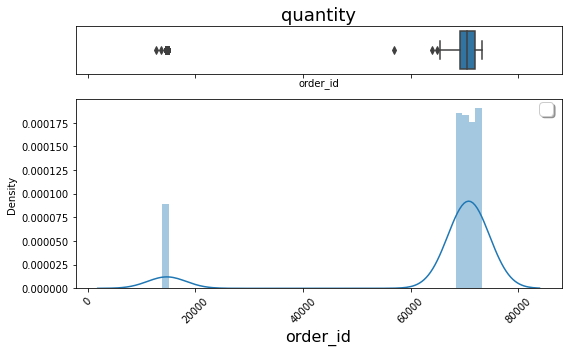

In [21]:
numerical_plotting(df, 'order_id', 'quantity')

**Наблюдение**.Можно заметить, что график распределения количества товаров в чеке относительно 
заказов скошен сильно вправо — возможен был бы эффект какого-то большого выброса или в целом заказы чаще содержат большое количество единиц товаров.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


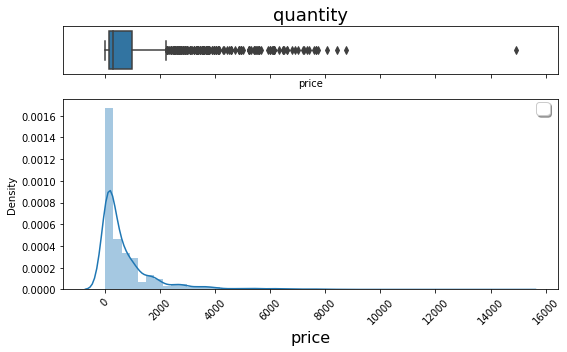

In [22]:
numerical_plotting(df, 'price', 'quantity')

**Наблюдение**. График распределения стоимостей товаров скошен влево — много дешёвых товаров, которые пользуются спросом.

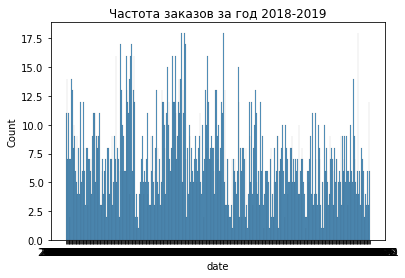

In [23]:
#График распределения покупок по времени до отчистки от выбросов. Интересно посмотреть
frequencyordering = sns.histplot(df['date']).set_title('Частота заказов за год 2018-2019')

**Наблюдение**. До очистки от выбросов на графике количества заказов по дням выделялся март, май, июль и поздняя осень.

Index(['date', 'customer_id', 'quantity'], dtype='object')

,date,customer_id,quantity
0,2018-10-01,11,115
1,2018-10-02,14,43
2,2018-10-03,7,16


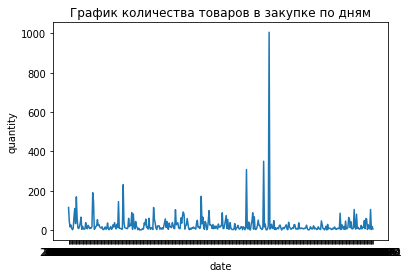

In [24]:
#график количества покупок и отдельно количества покупателей во времени с выбросами
timeline = pd.DataFrame(df.pivot_table(
index = 'date',
values  = {'quantity', 'customer_id'},
aggfunc = {'quantity': 'sum', 'customer_id': 'count'}
).sort_values('date', ascending = True).reset_index())

display(timeline.columns)
display(timeline.head(3))


sns.lineplot(data = timeline, x = 'date', y = 'quantity').set_title('График количества товаров в закупке по дням')
plt.show()

**Наблюдение**. До очистки здесь был виден выброс в летний период — возможно, акция, которая привлекла много заказов (но не обязательно пользователей).

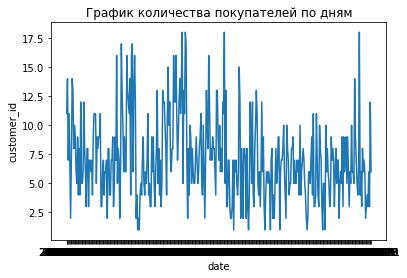

In [25]:
sns.lineplot(data = timeline, x="date", y='customer_id').set_title('График количества покупателей по дням')
plt.show()

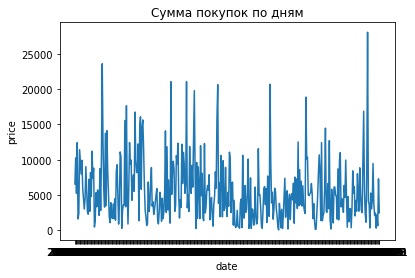

In [26]:
#Одно дело покупатели, а сколько они принесли денег?
totalperday = df.pivot_table(
    index = 'date',
    values = 'price',
    aggfunc = 'sum'
).reset_index() #Постройте диаграмму, отображающую сумму покупок по дням.

totalperdayplot = sns.lineplot(data = totalperday, x = 'date', y = 'price').set_title('Сумма покупок по дням')
plt.show()

**Наблюдение**. А вот сумма покупок по дням, за исключением крупных покупок более 7-8 тысяч, выглядит менее драматично.

<Figure size 1440x1440 with 0 Axes>

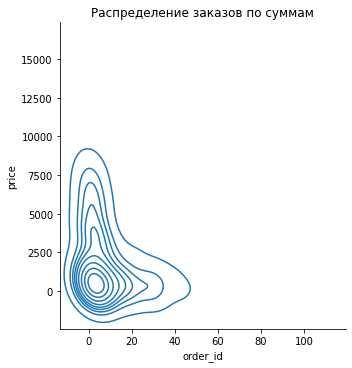

In [27]:
#Распределение заказов по сумме
orderprice = df.pivot_table(
    index = 'price',
    values = 'order_id',
    aggfunc = 'count'
).reset_index().sort_values('order_id', ascending = False)


plt.figure(figsize=(20, 20))
affordabilityplot = sns.displot(data=orderprice, x="order_id", y = 'price', kind="kde").set(title='Распределение заказов по суммам')
plt.show()

**Наблюдение**. Наши нормальные данные лежат где-то в области 7-10 заказов и до 1250 рублей за заказ (самый внутренний наиболее ровный кружочек).

In [28]:
orderprice.describe()

,price,order_id
count,345.00,345.00
mean,1654.51,8.07
std,2162.83,12.65
min,9.00,1.00
25%,202.00,1.00
50%,652.00,3.00
75%,2234.00,8.00
max,14917.00,105.00


**Налюдения**
Три четверти покупателей делают до 8 заказов. Будем это иметь в виду.

In [29]:
#Делим по квартилям (25-50-75-max) 

purchases_raw = df.pivot_table(
index = 'customer_id',
values  = {'order_id', 'quantity', 'price'},
aggfunc = {'order_id': 'count', 'quantity': 'sum', 'price': 'sum'} #Мне надо где-то на этом этапе сохранить категории, иначе смерджится в конце работы без них
).sort_values('order_id', ascending = False).reset_index()

purchases_raw.describe()

,order_id,price,quantity
count,2420.00,2420.00,2420.00
mean,1.15,893.65,4.28
std,2.67,2989.93,25.79
min,1.00,9.00,1.00
25%,1.00,134.00,1.00
50%,1.00,374.00,1.00
75%,1.00,1012.00,2.00
max,126.00,129778.00,1000.00


In [30]:
purchases_raw.tail()

,customer_id,order_id,price,quantity
2415,58e420e1-e083-4e77-929a-af4d8d0f4c8e,1,225.00,2
2416,5901a4c4-768d-4dc5-9d81-3546e29820fb,1,74.00,1
2417,59240d3e-58ce-4450-a5ef-68a693bfa903,1,1837.00,1
2418,5956b1f9-6d1b-4731-a38b-ce2434c499bd,1,712.00,1
2419,ffe82299-3f5b-4214-87fe-3d36ecccfac3,1,577.00,1


### Наблюдение по очищенным данным

Три четверти покупателей делают 1-2 заказа, чаще 1, и 2 покупки в заказе. Три четверти покупателей делают заказ до 1012 руб. В среднем 4 покупки. Максимальное кол-во заказов — 126, максимальная выручка с 1 клиента 129 778 руб. максимальное число позиций в заказе 1000.

In [31]:
print(purchases_raw.quantile([.95, .99]))

      order_id   price  quantity
0.95      2.00 3223.00     12.00
0.99      3.00 6771.95     50.81


До 95% заказывают 2 покупки на общую совокупную сумму до 3223 руб., в заказе до 12 позиций.

Более 51 покупки в заказе, или более 3 заказов, или выручка с клиента более 6772 рубля — аномальные.

In [32]:
print('Доля аномального числа закупок {:.3}%'.format(len(purchases_raw[purchases_raw['order_id'] > 3]) / len(purchases_raw) * 100))

Доля аномального числа закупок 0.331%


In [33]:
print('Что составляет {:.3}% годовой выручки.'.format(purchases_raw[purchases_raw['order_id'] > 3]['price'].sum() / purchases_raw['price'].sum() * 100))

Что составляет 8.51% годовой выручки.


In [34]:
purchases_raw['order_id'].value_counts()

1      2262
2       130
3        20
4         3
126       1
5         1
7         1
17        1
35        1
Name: order_id, dtype: int64

**По совету от тим-лида** решили, что обрезать по 99% нельзя, посмотрим на рейтинг клиентов с наиболее частыми заказами.

,customer_id,order_id
1891,c971fb21-d54c-4134-938f-16b62ee86d3b,126
731,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1087,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1725,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
16,0184f535-b60a-4914-a982-231e3f615206,5
688,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
2118,e0535076-6270-4df2-8621-cb06264a94fa,4
1796,bea7a833-2074-42db-bc49-4457abd3c930,4


[Text(0.5, 69.0, ''), Text(68.99999999999999, 0.5, '')]

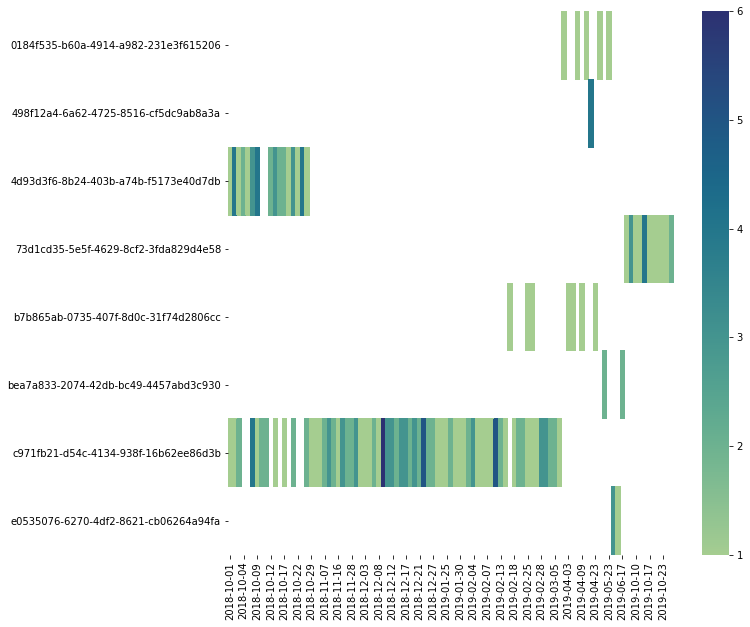

In [35]:
freqcust = purchases_raw.pivot_table(
    index = 'customer_id',
    values = 'order_id',
    aggfunc = 'sum'
).reset_index().sort_values('order_id', ascending = False)
display(freqcust.query('order_id > 3'))
thesecust = np.array(freqcust[freqcust['order_id'] > 3]['customer_id'])

thesecustomers = pd.DataFrame(df.query('customer_id in @thesecust'))
g = thesecustomers.pivot_table(
index = 'customer_id',
values = 'order_id',
columns = 'date',
aggfunc = 'count'
)
fig, ax = plt.subplots(figsize=(10,10)) 
d = sns.heatmap(g, cmap="crest")
d.set(xlabel="", ylabel="")


**Наблюдения**

Клиенты, которые покупали 5-7 раз выглядят более регулярными, клиент с 17 покупками в октябре — неясно, требует более длительных наблюдений. Возможно, это период закупок, а далее не вернется в магазин долго (как это вдруг случилось у клиентов с большим кол-вом покупок — раз и забросили магазин).

In [36]:
print(purchases_raw[purchases_raw['quantity'] > 51]['price'].sum())
print('Доля аномального количества позиций в заказе {:.3}%'.format(len(purchases_raw[purchases_raw['quantity'] > 51]) / len(purchases_raw) * 100))
print('Что составляет {:.3}% годовой выручки.'.format(purchases_raw[purchases_raw['quantity'] > 51]['price'].sum() / purchases_raw['price'].sum() * 100))

162127.0
Доля аномального количества позиций в заказе 0.992%
Что составляет 7.5% годовой выручки.


In [37]:
print(purchases_raw[purchases_raw['price'] > 6772]['price'].sum())
print('Количество аномальных покупателей {:.3}%'.format(len(purchases_raw[purchases_raw['price'] > 6772]) / len(purchases_raw) * 100))
print('и они принесли {:.3}% годовой выручки.'.format(purchases_raw[purchases_raw['price'] > 6772]['price'].sum() / purchases_raw['price'].sum() * 100))

368245.0
Количество аномальных покупателей 1.03%
и они принесли 17.0% годовой выручки.


### Наблюдения


*   Доля аномального количества позиций в заказе (более 51) 0.331%, что составляет 8.51% годовой выручки. 
*   Доля аномального числа закупок (более 3) 0.992%, что составляет 7.5% годовой выручки.
* Количество аномальных покупателей 1.03% и они принесли 17.0% годовой выручки.



## Варианты сегментации

Остановились на бенчмарке в 7 покупок в год.

In [38]:
#purchases_raw['id'] = purchases_raw['customer_id'].index

In [39]:
#Мы выяснили аномалии
#normcustomers  = purchases_raw.copy()

normcustomers = purchases_raw.loc[(purchases_raw['price'] < 6772) & (purchases_raw['order_id'] < 7) & (purchases_raw['quantity'] < 1000)]
display(normcustomers.describe())


normcustomers.to_csv('normcustomers.csv')

,order_id,price,quantity
count,2393.00,2393.00,2393.00
mean,1.07,749.29,3.66
std,0.31,1011.90,14.02
min,1.00,9.00,1.00
25%,1.00,134.00,1.00
50%,1.00,352.00,1.00
75%,1.00,974.00,2.00
max,5.00,6614.00,334.00


Я всё ещё надеюсь сдать проект, поэтому сохранила данные в датасет для дашборда.

## Кластеризация

In [40]:
#Составим сегменты с применением ML

In [41]:
final = normcustomers.pivot_table(
index = 'customer_id',
values = ['order_id', 'price', 'quantity'],
aggfunc = {'order_id':'count', 'price':'sum', 'quantity':'sum'}
).reset_index()
final

,customer_id,order_id,price,quantity
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,150.00,1
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.00,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,457.00,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.00,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1162.00,2
...,...,...,...,...
2388,ff601403-b094-4b86-9ac6-264d725b9277,1,1649.00,1
2389,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,397.00,1
2390,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,389.00,1
2391,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,974.00,1


In [42]:
sc = StandardScaler()
x_sc = sc.fit_transform(final.drop(columns = 'customer_id'))

In [43]:
km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(x_sc)
final['cluster_km'] = labels
linked = linkage(x_sc, method = 'ward')
clusters = final.groupby(['cluster_km']).mean()
print(clusters)

            order_id   price  quantity
cluster_km                            
0               1.00  390.11      3.08
1               1.00 2674.61      1.28
2               1.00  265.21    150.36


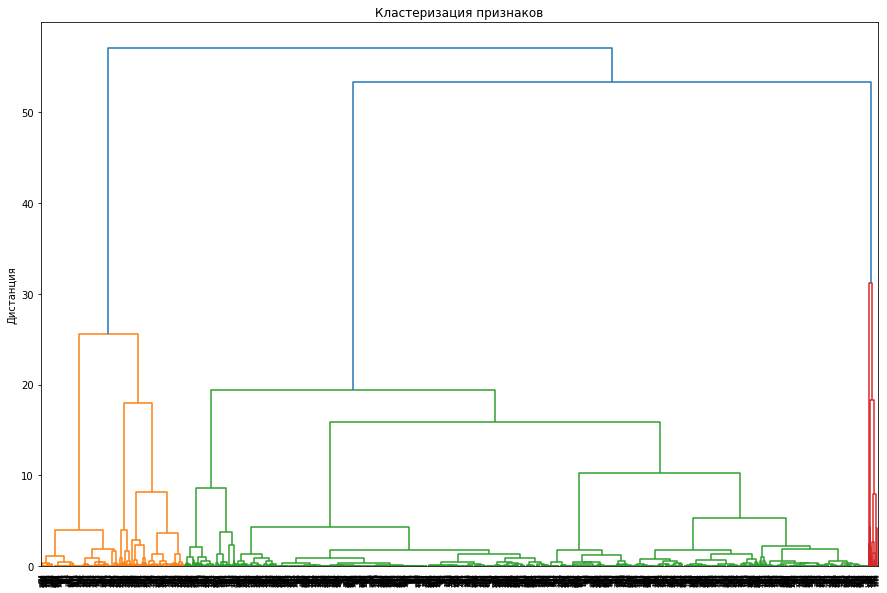

In [44]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.ylabel("Дистанция")
plt.title('Кластеризация признаков')
plt.show()

In [45]:
centroids = km.cluster_centers_
print(centroids)
centroids.shape

[[ 0.         -0.35502662 -0.04119353]
 [ 0.          1.90308226 -0.1698438 ]
 [ 0.         -0.47847954 10.46432602]]


(3, 3)

In [46]:
superfinal = final.groupby('cluster_km').mean().sort_values(by = 'price', ascending=False).reset_index()
superfinal.rename(columns={"index": "Mean Qty of Customers", "order_id": "Mean Nr of Purchases", 'price':'Mean Price per Bill', 'quantity':'Mean Qty of Items'})

,cluster_km,Mean Nr of Purchases,Mean Price per Bill,Mean Qty of Items
0,1,1.00,2674.61,1.28
1,0,1.00,390.11,3.08
2,2,1.00,265.21,150.36


In [47]:
#Нам осталось смёрджить и сделать  датасет для коллег из CRM

In [48]:
gettingcloser = pd.merge(normcustomers, final, on = 'customer_id')

In [49]:
customercluster = gettingcloser[['customer_id', 'cluster_km']]

In [50]:
segmentationdatabase = pd.merge(customercluster, df, on = 'customer_id')
segmentationdatabase['cluster_km'].value_counts()

0    2138
1     411
2      17
Name: cluster_km, dtype: int64

In [51]:
#Изучим верхнеуровнево кластеры vs категории товаров

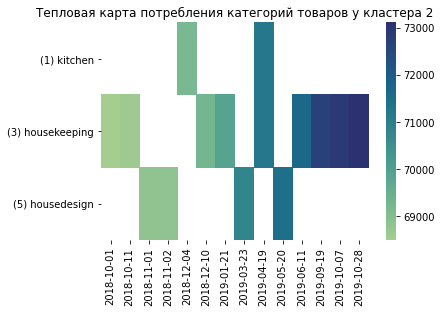

In [52]:
g = sns.heatmap(segmentationdatabase[segmentationdatabase['cluster_km'] == 2].pivot_table(
    index = 'category',
    columns = 'date',
    values = 'order_id'
), cmap="crest")

g.set(xlabel="", ylabel="")
g.set_title('Тепловая карта потребления категорий товаров у кластера 2')
plt.show()

Кластер два увеличил количество заказов по категории домохозяйства к концу октября 2019 года. Им можно рассылать предложения с акциями по категории товаров housekeeping (лучше, конечно, ещё подразобрать эту категорию).

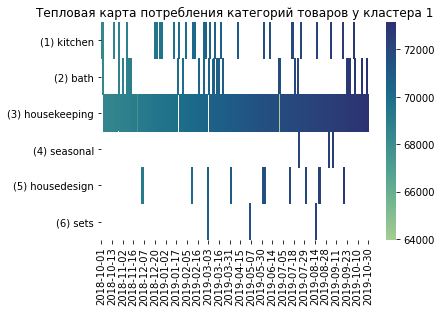

In [53]:
g = sns.heatmap(segmentationdatabase[segmentationdatabase['cluster_km'] == 1].pivot_table(
    index = 'category',
    columns = 'date',
    values = 'order_id'
), cmap="crest")

g.set(xlabel="", ylabel="")
g.set_title('Тепловая карта потребления категорий товаров у кластера 1')
plt.show()

Кластер 1 равномерно и регулярно делает закупки по товарам housekeeping. Им можно делать рассылку по новинкам в категории housekeeping и реже kitchen.

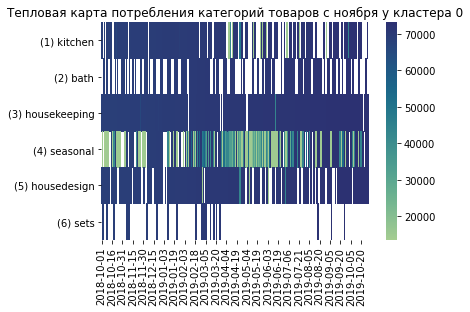

In [54]:
g = sns.heatmap(segmentationdatabase[segmentationdatabase['cluster_km'] == 0].pivot_table(
    index = 'category',
    columns = 'date',
    values = 'order_id'
), cmap="crest")

g.set(xlabel="", ylabel="")
g.set_title('Тепловая карта потребления категорий товаров с ноября у кластера 0')
plt.show()

Кластер 0 активно и постоянно покупает товары для хозяйства и дизайна, сезонно проявляет сильный интерес к елкам в Новый год и к сезонным растениям к концу лета. В остальное время проявляет интерес к кухонной утвари и дизайну с падением интереса в летний период. Так что можно круглогодично присылать новинки по housekeeping, зимой до середины весны про кухонную утварь, к лету и НГ — про сезонные новинки.

### Наблюдения


## Статистический анализ: разница между группами

Нулевая гипотеза H0: средние значения групп равны (отсутствуют различия в средних значениях групп)


Альтернативная гипотеза H1: по крайней мере, одно среднее значение группы отличается от других групп.

Если мы не задаемся целью протестировать все три группы разом, а попарно, то:



* Проверяем выборки на нормальность. У нас будут с ненормальным распределением, боксплот это покажет.
* Наши данные НЕ зависимы. Люди покупали товары сами по себе.
* Значит, нам понадобится критерий Манна-Уитни.

[Вот тут есть полезная таблица с типами тестов](https://agricolamz.github.io/DS_for_DH/%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D0%B3%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7.html)

In [55]:
clusterwise = segmentationdatabase.pivot_table(
index = 'cluster_km',
values = {'price', 'quantity', 'order_id'},
aggfunc = {'price':'sum', 'quantity':'sum', 'order_id':'count'}
).T
cols = clusterwise.columns
display(cols)
display(clusterwise)
segmentationdatabase.groupby('cluster_km')['price'].mean()


Int64Index([0, 1, 2], dtype='int64', name='cluster_km')

cluster_km,0,1,2
order_id,2138.00,411.00,17.00
price,781000.00,1008327.00,3713.00
quantity,6165.00,481.00,2105.00


cluster_km
0    365.29
1   2453.35
2    218.41
Name: price, dtype: float64

In [56]:
cluster0 = pd.DataFrame(segmentationdatabase[segmentationdatabase['cluster_km'] == 0]['price'])
cluster1 = pd.DataFrame(segmentationdatabase[segmentationdatabase['cluster_km'] == 1]['price'])
cluster2 = pd.DataFrame(segmentationdatabase[segmentationdatabase['cluster_km'] == 2]['price'])

In [57]:
df_melt = pd.melt(clusterwise.reset_index(), id_vars=['index'], value_vars=[0, 1, 2])
df_melt.columns = ['index', 'treatments', 'value']

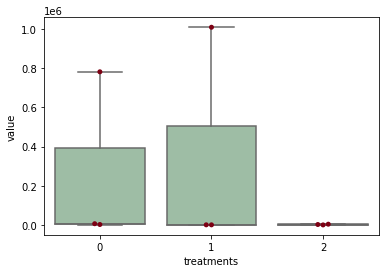

In [58]:
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


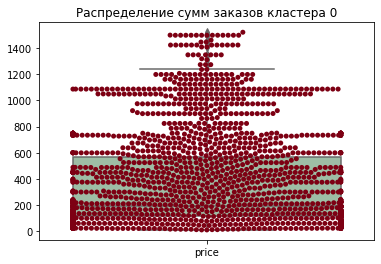

In [59]:
ax = sns.boxplot(data=cluster0, color='#99c2a2')
ax = sns.swarmplot(data=cluster0, color='#7d0013')
ax.set_title('Распределение сумм заказов кластера 0')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


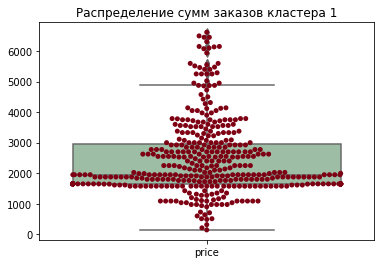

In [60]:
ax1 = sns.boxplot(data=cluster1, color='#99c2a2')
ax1 = sns.swarmplot(data=cluster1, color='#7d0013')
ax1.set_title('Распределение сумм заказов кластера 1')
plt.show()

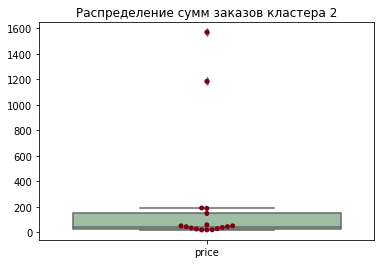

In [61]:
ax2 = sns.boxplot(data=cluster2, color='#99c2a2')
ax2 = sns.swarmplot(data=cluster2, color='#7d0013')
ax2.set_title('Распределение сумм заказов кластера 2')
plt.show()

Это ненормальное распределение.

In [62]:
#Однофакторный анализ групп с ненормальным распределением, размер меньше 30.
alpha = 0.05

display(stats.mannwhitneyu(clusterwise[0], clusterwise[1])) 
display(stats.mannwhitneyu(clusterwise[1], clusterwise[2])) 
display(stats.mannwhitneyu(clusterwise[0], clusterwise[2])) 

MannwhitneyuResult(statistic=6.0, pvalue=0.7)

MannwhitneyuResult(statistic=5.0, pvalue=1.0)

MannwhitneyuResult(statistic=8.0, pvalue=0.2)

**Наблюдения**
При сравнении кластеров 0-1-2 по сводной таблице Clusterwise ни одно из p-values 0,7; 1; 0,2 не меньше threshold в 0,05, у нас нет оснований отвергнуть гипотезу, что группы различаются. У нас нет достаточных доказательств, чтобы сказать, что истинные средние значения выборок 

In [63]:
display(stats.mannwhitneyu(cluster0, cluster1)) 
display(stats.mannwhitneyu(cluster1, cluster2)) 
display(stats.mannwhitneyu(cluster0, cluster2)) 

MannwhitneyuResult(statistic=array([11033.5]), pvalue=array([1.02905341e-215]))

MannwhitneyuResult(statistic=array([6902.]), pvalue=array([8.76507797e-12]))

MannwhitneyuResult(statistic=array([27740.]), pvalue=array([0.00018098]))

In [64]:
#Понимаю, что можно завернуть в элегантную форму, сорри
cluster0q = pd.DataFrame(segmentationdatabase[segmentationdatabase['cluster_km'] == 0]['quantity'])
cluster1q = pd.DataFrame(segmentationdatabase[segmentationdatabase['cluster_km'] == 1]['quantity'])
cluster2q = pd.DataFrame(segmentationdatabase[segmentationdatabase['cluster_km'] == 2]['quantity'])

Text(0.5, 1.0, 'Распределение количества товарных позиций к0')

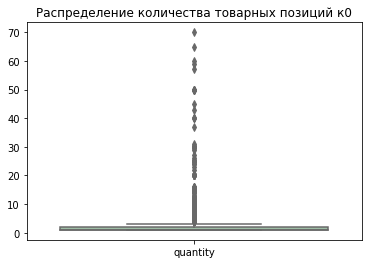

In [65]:
plt = sns.boxplot(data=cluster0q, color='#99c2a2')
plt.set_title('Распределение количества товарных позиций к0')

Text(0.5, 1.0, 'Распределение количества товарных позиций к1')

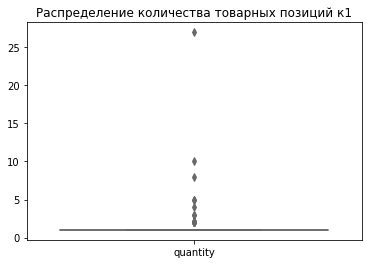

In [66]:
plt = sns.boxplot(data=cluster1q, color='#99c2a2')
plt.set_title('Распределение количества товарных позиций к1')

Text(0.5, 1.0, 'Распределение количества товарных позиций к2')

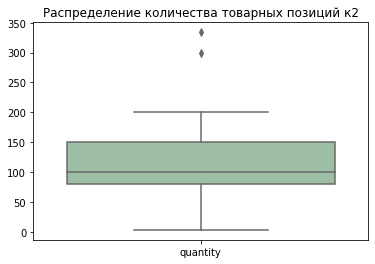

In [67]:
plt = sns.boxplot(data=cluster2q, color='#99c2a2')
plt.set_title('Распределение количества товарных позиций к2')

In [68]:
display(stats.mannwhitneyu(cluster0q, cluster1q)) 
display(stats.mannwhitneyu(cluster1q, cluster2q))
display(stats.mannwhitneyu(cluster0q, cluster2q)) 

MannwhitneyuResult(statistic=array([541941.]), pvalue=array([1.87854667e-23]))

MannwhitneyuResult(statistic=array([9.5]), pvalue=array([2.54025873e-45]))

MannwhitneyuResult(statistic=array([585.5]), pvalue=array([5.71502623e-18]))

**Наблюдения**

При сравнении кластеров 0 и 2 по таблице segmentationsdatabase есть основания считать, что кластеры 0 и 2 имеют стат.значимые отличия по параметру стоимости чека за заказ, по количеству товарных единиц стат.значимая разница не обнаружена.

# Выводы

**По неочищенным данным**

В датасете доля дубликатов была более половины.
График распределения количества товаров в чеке относительно заказов скошен сильно вправо — возможен был бы эффект какого-то большого выброса или в целом заказы чаще содержат большое количество единиц товаров. До очистки был виден выброс в летний период — возможно, акция, которая привлекла много заказов (но не обязательно пользователей). Много дешёвых товаров, которые пользуются спросом. Сезонность выражена весной и летом.

**Наблюдение по очищенным данным**

Три четверти покупателей делают 1-2 заказа, чаще 1, и 2 покупки в заказе. Три четверти покупателей делают заказ до 1012 руб. Более 6772 руб. — аномальное значение чека.


В среднем 4 покупки. Максимальное кол-во заказов — 126, максимальная выручка с 1 клиента 129 778 руб. максимальное число позиций в заказе 1000.

Доля аномального количества позиций в заказе (более 51) 0.331%, что составляет 8.51% годовой выручки.
Доля аномального числа закупок (более 3) 0.992%, что составляет 7.5% годовой выручки.
Количество аномальных покупателей 1.03% и они принесли 17.0% годовой выручки.

**Бенчмарк**

Отсекаем более 7 заказов в год. Дополнительные фильтры (99% кв.): чек не более 6772 рубля и менее 1000 товарных единиц.

**Кластеризация**


Кластер два увеличил количество заказов по категории домохозяйства к концу октября 2019 года. Им можно рассылать предложения с акциями по категории товаров housekeeping (лучше, конечно, ещё подразобрать эту категорию).

Кластер 1 равномерно и регулярно делает закупки по товарам housekeeping. Им можно делать рассылку по новинкам в категории housekeeping и реже kitchen.

Кластер 0 активно и постоянно покупает товары для хозяйства и дизайна, сезонно проявляет сильный интерес к елкам в Новый год и к сезонным растениям к концу лета. В остальное время проявляет интерес к кухонной утвари и дизайну с падением интереса в летний период. Так что можно круглогодично присылать новинки по housekeeping, зимой до середины весны про кухонную утварь, к лету и НГ — про сезонные новинки.

**Тестирование**

Распределение стоимостей заказов в кластерах ненормальное, выборки небольшие. Применён критерий Манна-Уитни.

При сравнении кластеров 0 и 2 по таблице segmentationsdatabase есть основания считать, что кластеры 0 и 2 имеют стат.значимые отличия по параметру стоимости чека за заказ. Были сравнены все стоимости попавших в базу заказов.

При сравнении кластеров 0-1-2 по сводной таблице clusterwise ни одно из p-values 0,4; 1; 0,2 не меньше threshold в 0,05, у нас нет оснований отвергнуть гипотезу, что группы различаются. У нас нет достаточных доказательств, чтобы сказать, что истинные средние значения выборок. Были сравнены суммарные значения параметров кластеров.